<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_6_3_RNN_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
import torch
from torch import nn
import datasets as ds
from pprint import pprint
from tqdm import tqdm
from matplotlib import pyplot as plt


dataset = ds.load_dataset("glue", "sst2")

sentence_list = dataset["train"]["sentence"]
labels_list   = dataset["train"]["label"]
tokenize      = lambda x: x.split()
tokenized     = list(map(tokenize, sentence_list))

from torchtext.vocab import build_vocab_from_iterator
vocab = build_vocab_from_iterator(tokenized, specials=["<UNK>"], min_freq=5)
vocab.set_default_index(0)

func = lambda x: torch.tensor(vocab(x))
integer_tokens = list(map(func, tokenized))
label_tensors  = list(map(torch.tensor, labels_list))
print(*sentence_list[1:3], sep="\n")
print(*integer_tokens[1:3], sep="\n")
print(*label_tensors[1:3], sep="\n")

test_split   = len(integer_tokens) * 8//10
train_tokens = integer_tokens[:test_split]
train_labels = label_tensors[:test_split]
test_tokens  = integer_tokens[test_split:]
test_labels  = label_tensors[test_split:]

Reusing dataset glue (/root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

contains no wit , only labored gags 
that loves its characters and communicates something rather beautiful about human nature 
tensor([2924,   61,  330,    2,   89, 1993,  549])
tensor([  10, 1792,   17,   54,    4, 6088,   96,  186,  265,   34,  178,  627])
tensor(0)
tensor(1)


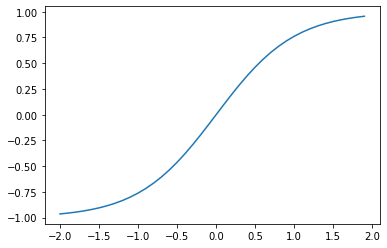

In [ ]:
tanh = nn.Tanh()
x    = torch.arange(-2,2,0.1)
y    = tanh(x)
plt.plot(x,y);

In [ ]:
class MyRNNCell(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_state = torch.zeros(hidden_dim)
        self.hidden_linear= nn.Linear(in_features = hidden_dim,
                                     out_features = hidden_dim)
        self.input_linear = nn.Linear(in_features = embed_dim,
                                     out_features = hidden_dim)
        self.activation   = nn.Tanh()
    def forward(self, one_embedded_token):
        Z1        = self.input_linear(one_embedded_token)
        Z2        = self.hidden_linear(self.hidden_state)
        Y         = Z1+Z2
        new_state = self.activation(Y)
        self.hidden_state = new_state
        #return

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding  = nn.Embedding(len(vocab),embed_dim)
        self.rnn        = MyRNNCell(embed_dim, hidden_dim)
        self.linear     = nn.Linear(hidden_dim, 2)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, sentence_tokens):
      self.rnn.hidden_state = torch.zeros(self.hidden_dim)
      for one_token in sentence_tokens:
        one_embedded_token = self.embedding(one_token)
        self.rnn(one_embedded_token)

      feature_extractor_output = self.rnn.hidden_state
      class_scores       = self.linear(feature_extractor_output)
      logprobs           = self.logsoftmax(class_scores)
      return logprobs

In [ ]:
class DeepRNNClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding  = nn.Embedding(len(vocab), embed_dim)
        self.rnn1    = MyRNNCell(embed_dim, hidden_dim)
        self.rnn2    = MyRNNCell(hidden_dim, hidden_dim)      #
        self.linear     = nn.Linear(hidden_dim, 2)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, sentence_tokens):
      self.rnn1.hidden_state = torch.zeros(self.hidden_dim)
      self.rnn2.hidden_state = torch.zeros(self.hidden_dim)   #
      for one_token in sentence_tokens:
        one_embedded_token = self.embedding(one_token)
        self.rnn1(one_embedded_token)
        self.rnn2(self.rnn1.hidden_state)                     #

      feature_extractor_output = self.rnn2.hidden_state       #
      class_scores     = self.linear(feature_extractor_output)
      logprobs         = self.logsoftmax(class_scores)
      return logprobs

In [ ]:
class FasterDeepRNNClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim, RNNlayers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding  = nn.Embedding(len(vocab), embed_dim)  
        self.rnn_stack  = nn.RNN(embed_dim,                   #
                                 hidden_dim,
                                 RNNlayers)  
        self.linear     = nn.Linear(hidden_dim, 2)
        self.logsoftmax = nn.LogSoftmax(dim=0)

    def forward(self, sentence_tokens):
      all_embeddings         = self.embedding(sentence_tokens)
      all_embeddings         = all_embeddings.unsqueeze(1)
      hidden_state_history, _= self.rnn_stack(all_embeddings)

      feature_extractor_output = hidden_state_history[-1,0,:]
      class_scores     = self.linear(feature_extractor_output)
      logprobs         = self.logsoftmax(class_scores)
      return logprobs

In [ ]:
class LSTMclassifier(FasterDeepRNNClassifier):
    def __init__(self, embed_dim, hidden_dim, RNNlayers):
      super().__init__(embed_dim, hidden_dim, RNNlayers)
      self.rnn_stack = nn.LSTM(embed_dim, hidden_dim, RNNlayers) 

In [ ]:
model     = FasterDeepRNNClassifier(10,10,2)
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
def iterate_one_sentence(tokens, label, train_flag):
  if train_flag:
    model.train()  
    optimizer.zero_grad()
    y_model = model(tokens)
    loss    = -y_model[label] #Cross Entropy
    loss.backward()
    optimizer.step()
  else:
    model.eval()
    y_model = model(tokens)
    model.train()
  with torch.no_grad():
    predicted_labels = y_model.argmax()
    success = (predicted_labels == label)
  return success

In [ ]:
#overfit a small batch to check if learning _can_ occur
num_samples, epochs = 100, 10
parameters = list(model.parameters())
avg_grad_norms = torch.zeros(epochs)
for epoch in range(epochs):
  correct_predictions = torch.tensor([0.])
  grad_norm_temp      = torch.zeros(num_samples)
  for idx in tqdm(range(num_samples)):
    correct_predictions += iterate_one_sentence(train_tokens[idx],
                                                train_labels[idx],
                                                train_flag=True)
    norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
    grad_norm_temp[idx] = torch.max(torch.stack(norms))
  avg_grad_norms[epoch] = grad_norm_temp.mean()
    
  acc = correct_predictions/num_samples
  if epoch % 3 == 0:
    print("Epoch",epoch," acc:",acc.item())

100%|██████████| 100/100 [00:00<00:00, 139.34it/s]


Epoch 0  acc: 0.4300000071525574


100%|██████████| 100/100 [00:00<00:00, 178.62it/s]


Epoch 3  acc: 0.6200000047683716


100%|██████████| 100/100 [00:00<00:00, 230.73it/s]


Epoch 6  acc: 0.7799999713897705


100%|██████████| 100/100 [00:00<00:00, 117.46it/s]

Epoch 9  acc: 0.8899999856948853


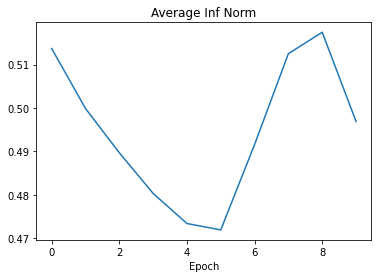

In [ ]:
plt.plot(avg_grad_norms)
plt.xlabel("Epoch")
plt.title("Average Inf Norm");

In [ ]:
test_correct_predictions = torch.tensor([0.])
for tokens, label in tqdm(zip(test_tokens, test_labels), total=len(test_tokens)):
  test_correct_predictions += iterate_one_sentence(tokens, label, train_flag=False)
test_acc = test_correct_predictions / len(test_tokens)


100%|██████████| 13470/13470 [00:15<00:00, 866.04it/s] 


In [ ]:
print(acc, test_acc, sep="\n")

tensor([0.8900])
tensor([0.5030])


In [ ]:
preprocess = lambda x: torch.tensor(vocab(x.split()))
example_sentences=["very good , not bad",
                   "very bad , not good"]
with torch.no_grad():                   
  for sent in example_sentences:
    print(preprocess(sent))
    print(torch.exp(model(preprocess(sent))))

tensor([77, 46,  2, 33, 74])
tensor([0.2383, 0.7617])
tensor([77, 74,  2, 33, 46])
tensor([0.0527, 0.9473])
